# Model Comparison
here the two winning models, one from algorithm 1 and one from algorithm 2 will be compared. The two models will be either AdaBoost or Random forest for 1, and SVC for 2. The training set will undergo preprocessing, then simple oversampling for both models. 5 fold CV will be examined for both models. Finally, both models will be trained on the entire training set, then performance will be analyzed on the validation set. Cohen's Kappa will be calculated to determine the level of agreement between the models. T-tests will be performed to determine if there is a significant difference between the models in terms of accuracy, f1-scores, precision, and recall. This will be done using the random-state when training the model. Difference between train and test scores will also be evaluated, as a larger difference implies more over fitting, which results in poor generalizability.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use("seaborn-v0_8")
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.base import TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn import metrics
from sklearn.pipeline import Pipeline
#from treeinterpreter import treeinterpreter as ti
import nltk
from nltk.corpus import wordnet
import spacy
nlp=spacy.load('en_core_web_sm')
from spacy.lang.en import English

from nltk.stem.wordnet import WordNetLemmatizer

import seaborn as sns
import base64
import string
import re

import sys
import os

from NLP_LLIS_files.lesson_selection_functions import *

datasheet_path = os.path.join(os.getcwd(),'LLIS datasheets','')

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
topic_stopwords =   ["ames","armstrong","glenn","goddard","katherine","johnson",
                    "jpl","kennedy","langley","marshall","michoud","nasa","plum",
                    "brook","stennis","wallops","white","sands","sand","sandusky",
                    "ohio","cleveland","fairmont","west","virginia","greenbelt",
                    "maryland","virginia","washington","hampton","florida",
                    "huntsville","alabama","mississippi","orleans","louisiana",
                    "houston","texas","las","cruces","mexico","dryden","edwards",
                    "california","pasadena","moffett","field","york","albuquerque",
                    "robert","moscow","sofia", "january", "february", "march", 
                    "april", "may","june", "july", "august", "september", "october", 
                    "november", "december", "csoc", "gsfc", "cofr", "keyword",
                    "germany", "russia", "inch", "meter", "usml", "morning",
                    "also", "lesson", "learn", "lockheed", "martin", "northrop", "grumman",
                    "determine", "pick", "canoga", "park", "william", "think", "please",
                    "refer", "totally", "month", "day", "year", "vandenberg", "senior",
                    "msfc","cause"]
STOPLIST = set(stopwords + topic_stopwords)
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

In [3]:
def encode (df):
    target_names = []
    for i in range(0, len(df)):
        target_names.append(df.iloc[i]['use'])
        if df.iloc[i]['use'] == "use":
            df.at[i,'use']=float(1)
        else: df.at[i,'use']= float(0)
    df["target names"] = target_names

In [4]:
train_df = preprocessing(datasheet_path+"train_set_expanded_H.csv")
#calculating features for 1 add encoding
model1_train,scores = process_data(train_df.copy())
encode(model1_train)

model2_train = train_df
display(model1_train, model2_train)

,Lesson ID,use,text,positive sentiment,negative sentiment,objective sentiment,engineering relevance,failure relevance,success relevance,design relevance,management relevance,length,target names
0,28105,1.0,high oxidizer vapor content may cause vapor r...,0.014744,0.020382,0.445360,0.078057,0.016479,0.004337,0.008673,0.026019,6701,use
1,25503,1.0,highly configurable software architecture all...,0.027885,0.025962,0.469231,0.107692,0.023077,0.007692,0.007692,0.053846,769,use
2,24403,1.0,bird-strike hazard outside of landing takeoff...,0.018750,0.031731,0.445673,0.053846,0.023077,0.007692,0.019231,0.019231,1556,use
3,23701,1.0,robot li-ion battery fire a non-flight robot ...,0.010635,0.018734,0.410422,0.043194,0.015052,0.004581,0.018325,0.030759,8507,use
4,23201,1.0,rapidscat power subsystem failure the failure...,0.017857,0.019965,0.415551,0.032738,0.020833,0.002976,0.018849,0.011905,5699,use
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,389,1.0,in-flight power converter failure during a sw...,0.007056,0.010081,0.482863,0.056452,0.028226,0.004032,0.036290,0.012097,1535,use
295,308,1.0,solder balls in flight modules because a desi...,0.015528,0.031832,0.443323,0.062112,0.024845,0.006211,0.049689,0.006211,942,use
296,378,1.0,untestable system mode in flight an essential...,0.019389,0.030528,0.441832,0.062706,0.023102,0.006601,0.046205,0.013201,1813,use
297,374,1.0,higher data rates possible through station ar...,0.028107,0.014053,0.407544,0.044379,0.011834,0.011834,0.023669,0.026627,1952,use


,Lesson ID,use,text
0,28105,use,high oxidizer vapor content may cause vapor r...
1,25503,use,highly configurable software architecture all...
2,24403,use,bird-strike hazard outside of landing takeoff...
3,23701,use,robot li-ion battery fire a non-flight robot ...
4,23201,use,rapidscat power subsystem failure the failure...
...,...,...,...
294,389,use,in-flight power converter failure during a sw...
295,308,use,solder balls in flight modules because a desi...
296,378,use,untestable system mode in flight an essential...
297,374,use,higher data rates possible through station ar...


In [5]:
df_validation = preprocessing(datasheet_path+"validation_set_final_H.csv")
display(df_validation)
model1_validation,scores = process_data(df_validation.copy())
encode(model1_validation)

,Lesson ID,use,text
0,17802,use,msfc case study: x-34 fastrac - memorandums o...
1,16901,use,propellant tank protection against orbital de...
2,16501,use,smap reflector deployment test anomaly (desig...
3,15301,use,fidelity of the dawn thrust gimbal assembly l...
4,1710,use,"uninhabited aerial vehicle (uav), flight test..."
...,...,...,...
94,1,use,implementation of procedural controls in addi...
95,385,use,hydra-set* applications and hazards lifting i...
96,392,use,galileo aacs excessive memory keep alive (mka...
97,383,use,galileo aacs computer memory access contentio...


In [6]:
features = ["positive sentiment", "negative sentiment","objective sentiment","engineering relevance",
                "failure relevance","success relevance","design relevance", "length", "management relevance"]
model1 = RandomForestClassifier(n_estimators=300,max_depth=4, random_state=0)#, class_weight="balanced")

In [7]:
class CleanTextTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text

def tokenizeText(sample):
    tokens = nlp(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

In [8]:
tfidf_vector = TfidfVectorizer(tokenizer = tokenizeText)

In [9]:
clf =svm.LinearSVC(class_weight="balanced")
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', tfidf_vector),('clf',clf)])

In [13]:
models = [model1, pipe]
training = [model1_train[features], model2_train['text']]
labels = [model1_train["use"].astype(int), model2_train['use']]
av_acc = []; av_f1 = []; av_recall = [];av_precision = []; false_positives = []; false_negatives = []
for i in range (2):
    model = models[i]
    train = training[i]
    label = labels[i]
    
    false_pos = []; false_neg = []
    
    accuracies = []
    dfs = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    folds = []
    conf_matrices = []
    precision = []
    recall = []
    f1 = []
    j = 1
    for train_index, test_index in kf.split(train,label):
        X_train = train.iloc[train_index]
        X_test = train.iloc[test_index]
        y_train = label.iloc[train_index]
        y_test = label.loc[test_index]

        #Train the model and analyze results
        #if i != 1: 
        model.fit(X_train, y_train)
        
        #else: model.fit_transform(X_train, y_train)
        
        accuracies.append(accuracy_score(y_test, model.predict(X_test)))
        
        conf_matrices.append(confusion_matrix(y_test,model.predict(X_test)))
        false_pos.append(confusion_matrix(y_test,model.predict(X_test))[0:0,1:1])
        false_neg.append(confusion_matrix(y_test,model.predict(X_test))[0:1,1:0])
        folds.append(j)
    
        f1.append(f1_score(y_test, model.predict(X_test), average="macro"))
        precision.append(precision_score(y_test, model.predict(X_test),average="macro"))
        recall.append(recall_score(y_test, model.predict(X_test), average="macro"))

        # how many occurances appear in the train set
        s_train = label.iloc[train_index].value_counts()
        s_train.name = f"train {j}"
        s_test = label.iloc[test_index].value_counts()
        s_test.name = f"test {j}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        j += 1

    results = pd.DataFrame({
        "fold":folds,
        "accuracy":accuracies,
        "recall score": recall,
        "precision score": precision,
        "f1 score": f1,
        "confusion matrix":conf_matrices,
    })
    #display(results)
    
    av_recall.append(np.average(recall)); av_acc.append(np.average(accuracies))
    av_f1.append(np.average(f1));av_precision.append(np.average(precision))
    false_positives.append(np.average(false_pos)); false_negatives.append(np.average(false_neg))

pd.concat(dfs,axis=1, sort=False)
av = pd.DataFrame({
    "model": models,
    "average accuracy": av_acc,
    "average f1": av_f1,
    "average precision": av_precision,
    "average recall": av_recall,
    "average number of false positives": false_positives,
    "average number of false negatives": false_negatives
})

display(av)
    

,model,average accuracy,average f1,average precision,average recall,average number of false positives,average number of false negatives
0,"(DecisionTreeClassifier(max_depth=4, max_featu...",0.876102,0.777789,0.839764,0.745833,NaN,NaN
1,(<__main__.CleanTextTransformer object at 0x00...,0.862825,0.742128,0.820198,0.712585,NaN,NaN


In [14]:
models = [model1, pipe]
train_acc = []; test_acc = []; train_f1 = []; test_f1 = []; train_pre = []; test_pre = [];train_recall = []; test_recall = []; conf_matr=[]
model_names = ['random forest', 'SVC-NLP']
validations = [model1_validation[features], df_validation['text']]
validation_labels = [model1_validation['use'].astype(int), df_validation['use']]
training = [model1_train[features], model2_train['text']]
labels = [model1_train["use"].astype(int), model2_train['use']]
predictions = []
for i in range(2):
    model = models[i]
    train = training[i]
    label = labels[i]
    validation = validations[i]
    validation_label=validation_labels[i]
    model.fit(train,label)
    pred = model.predict(validation)
    train_acc.append(accuracy_score(label, model.predict(train))); 
    test_acc.append(accuracy_score(validation_label, pred))
    train_f1.append(f1_score(label, model.predict(train),average="macro")); test_f1.append(f1_score(validation_label, pred, average="macro"))
    train_pre.append(precision_score(label, model.predict(train),average="macro")); test_pre.append(precision_score(validation_label, pred, average="macro"))
    train_recall.append(recall_score(label, model.predict(train),average="macro")); test_recall.append(recall_score(validation_label, pred, average="macro"))
    conf_matr.append(confusion_matrix(validation_label, pred))
    predictions.append(pred)
    
results = pd.DataFrame({
    "model":model_names,
    "train accuracy": train_acc,
    "test accuracy":test_acc,
    "train f1": train_f1,
    "test f1": test_f1,
    "train precision": train_pre,
    "test precision": test_pre,
    "train recall": train_recall,
    "test recall": test_recall,
    "confusion matrix": conf_matr
})
display(results)

,model,train accuracy,test accuracy,train f1,test f1,train precision,test precision,train recall,test recall,confusion matrix
0,random forest,0.929766,0.919192,0.874913,0.833613,0.929960,0.855546,0.838604,0.815476,"[[10, 5], [3, 81]]"
1,SVC-NLP,0.996656,0.919192,0.994687,0.833613,0.991525,0.855546,0.997925,0.815476,"[[10, 5], [3, 81]]"


In [13]:
del_acc = [train_acc[i]-test_acc[i] for i in range(len(train_acc))]
del_f1 = [train_f1[i]-test_f1[i] for i in range(len(train_acc))]
del_pre = [train_pre[i]-test_pre[i] for i in range(len(train_acc))]
del_recall = [train_recall[i]-test_recall[i] for i in range(len(train_acc))]
dels = pd.DataFrame({
    "model":model_names, "accuracy": del_acc, "f1": del_f1, "precision": del_pre, "recall":del_recall
})
dels

,model,accuracy,f1,precision,recall
0,random forest,0.010574,0.041299,0.074414,0.023127
1,SVC-NLP,0.077464,0.161074,0.135980,0.182449


In [14]:
for i in range(2):
    print(model_names[i],metrics.classification_report(validation_labels[i], predictions[i]))

random forest               precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.94      0.96      0.95        84

    accuracy                           0.92        99
   macro avg       0.86      0.82      0.83        99
weighted avg       0.92      0.92      0.92        99

SVC-NLP               precision    recall  f1-score   support

     not use       0.77      0.67      0.71        15
         use       0.94      0.96      0.95        84

    accuracy                           0.92        99
   macro avg       0.86      0.82      0.83        99
weighted avg       0.92      0.92      0.92        99



In [15]:
encode_dict = {"use":1, "not use":0}
SVC = [encode_dict[key] for key in predictions[1]]
predictions[1]=SVC
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(predictions[0].tolist(), predictions[1])
print("validation kappa: ", kappa)

validation kappa:  0.6457960644007155


In [16]:
j=0
for i in range (len(predictions[1])):
    if predictions[0][i] != predictions[1][i]:j+=1
print("the models disagree on", j, "predictions")

the models disagree on 8 predictions


In [17]:
#predictions[0]=predictions[0].tolist()
import pingouin as pg
alpha = pg.cronbach_alpha(data = pd.DataFrame({"RF":predictions[0], "NLP":predictions[1]}))
print("validation alpha: ", alpha)
#pd.DataFrame({"RF":predictions[0], "NLP":predictions[1]})

validation alpha:  (0.78478260869565, array([0.679, 0.855]))


# Final model and lesson selection
the random forest model was chosen to complete the final lesson selection. It was trained on the 400 labeled data (previously seperate training/test and validation sets), then the trained model classified all remaning documents. A list of lesson numbers were provided and used to construct the dataset

In [18]:
train_df = preprocessing(datasheet_path+"train_set_expanded_H.csv")
df_validation = preprocessing(datasheet_path+"validation_set_final_H.csv")
train_df = pd.concat([train_df, df_validation], axis=0).reset_index()
#display(train_df)
train_df, data = process_data(train_df.reset_index())
display(train_df)

,level_0,index,Lesson ID,use,text,positive sentiment,negative sentiment,objective sentiment,engineering relevance,failure relevance,success relevance,design relevance,management relevance,length
0,0,0,28105,use,high oxidizer vapor content may cause vapor r...,0.014744,0.020382,0.445360,0.078057,0.016479,0.004337,0.008673,0.026019,6701
1,1,1,25503,use,highly configurable software architecture all...,0.027885,0.025962,0.469231,0.107692,0.023077,0.007692,0.007692,0.053846,769
2,2,2,24403,use,bird-strike hazard outside of landing takeoff...,0.018750,0.031731,0.445673,0.053846,0.023077,0.007692,0.019231,0.019231,1556
3,3,3,23701,use,robot li-ion battery fire a non-flight robot ...,0.010635,0.018734,0.410422,0.043194,0.015052,0.004581,0.018325,0.030759,8507
4,4,4,23201,use,rapidscat power subsystem failure the failure...,0.017857,0.019965,0.415551,0.032738,0.020833,0.002976,0.018849,0.011905,5699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,393,94,1,use,implementation of procedural controls in addi...,0.004032,0.012903,0.383065,0.077419,0.019355,0.000000,0.012903,0.019355,968
394,394,95,385,use,hydra-set* applications and hazards lifting i...,0.011411,0.029046,0.415975,0.058091,0.037344,0.000000,0.008299,0.008299,1507
395,395,96,392,use,galileo aacs excessive memory keep alive (mka...,0.018868,0.016903,0.404481,0.056604,0.003145,0.000000,0.047170,0.009434,1762
396,396,97,383,use,galileo aacs computer memory access contentio...,0.009804,0.042017,0.432773,0.050420,0.030812,0.000000,0.039216,0.008403,2246


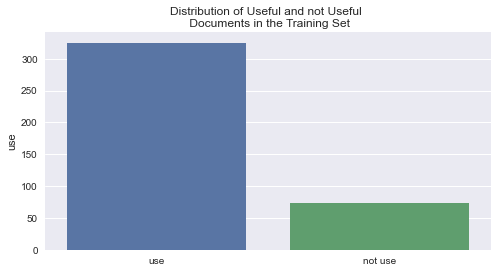

use        325
not use     73
Name: use, dtype: int64


In [19]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(8,4))
sns.barplot(x = train_df['use'].unique(), y=train_df['use'].value_counts())
plt.title("Distribution of Useful and not Useful \n Documents in the Training Set")
plt.show()

print(train_df['use'].value_counts())

In [20]:
training_lesson_numbers = [train_df.iloc[i]['Lesson ID'] for i in range(len(train_df))]
LL = preprocessing(datasheet_path+"lessons_learned_2020-12-03.csv")
print(len(LL))
indicies_to_drop = [i for i in range(0, len(LL)) if LL.iloc[i]['Lesson ID'] in training_lesson_numbers]
LL = LL.drop(indicies_to_drop)
print(len(LL))

2096
1698


In [21]:
LL, scores = process_data(LL)

In [22]:
encode(train_df)

In [23]:
features = ["positive sentiment", "negative sentiment","objective sentiment","engineering relevance",
                "failure relevance","success relevance","design relevance", "length", "management relevance"]
model = RandomForestClassifier(n_estimators=300,max_depth=4, random_state=0)

In [24]:
clf = svm.SVC(kernel="linear", C=1.9, class_weight="balanced")
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', tfidf_vector),('clf',clf)])

In [25]:
model.fit(train_df[features], train_df['use'].astype(int))
classifications_RF = model.predict(LL[features])
pipe.fit(train_df['text'], train_df['use'].astype(int))
classifications_NLP = pipe.predict(LL['text'])

In [26]:
decode = {1:'use', 0:'not use'}
classifications_NLP = [decode[val] for val in classifications_NLP]
classifications_RF = [decode[val] for val in classifications_RF]

In [27]:
nlp = pd.read_csv(os.path.join(os.getcwd(), "LLIS datasheets","NLP_useable_LL.csv"))
lexicon = pd.read_csv(os.path.join(os.getcwd(), "LLIS datasheets", "useable_LL.csv"))
total = pd.read_csv(os.path.join(os.getcwd(), "LLIS datasheets", "lessons_learned_2020-12-03.csv"))
id_col = "Lesson ID"

nlp_ids = nlp[id_col].to_list()
lexicon_ids = lexicon[id_col].to_list()
indices_to_keep = []
indices_to_drop = []
for i in range(len(total)):
    if total.at[i,id_col] not in nlp_ids or total.at[i,id_col] not in lexicon_ids:
        indices_to_drop.append(i)
    if total.at[i,id_col] in nlp_ids and total.at[i,id_col] in lexicon_ids:
        indices_to_keep.append(i)
total_correct = total.drop(indices_to_drop).reset_index(drop=True)
print(len(total_correct), len(indices_to_keep))
#total_correct.to_csv(os.path.join(os.getcwd(), "LLIS datasheets","Combined_LLIS.csv"))

1709 1709
